In [1]:
import time
from pathlib import Path
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np

from trajdata import MapAPI, VectorMap
from trajdata.caching.df_cache import DataFrameCache
from trajdata.caching.env_cache import EnvCache
from trajdata.caching.scene_cache import SceneCache
from trajdata.data_structures.scene_metadata import Scene
from trajdata.maps.vec_map import Polyline, RoadLane
from trajdata.utils import map_utils


def load_random_scene(cache_path: Path, env_name: str, scene_dt: float) -> Scene:
    env_cache = EnvCache(cache_path)
    scenes_list = env_cache.load_env_scenes_list(env_name)
    random_scene_name = scenes_list[np.random.randint(0, len(scenes_list))].name

    return env_cache.load_scene(env_name, random_scene_name, scene_dt)

Randomly chose nusc_mini, boston-seaport map.
interpolate (max_dist) took 1.47 ms
interpolate (num_pts) took 0.40 ms
project_onto (15 points) took 0.48 ms


get_closest_lane took 0.22 ms


get_lanes_within took 0.49 ms


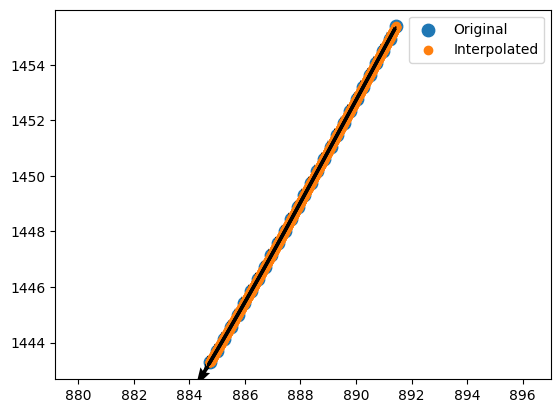

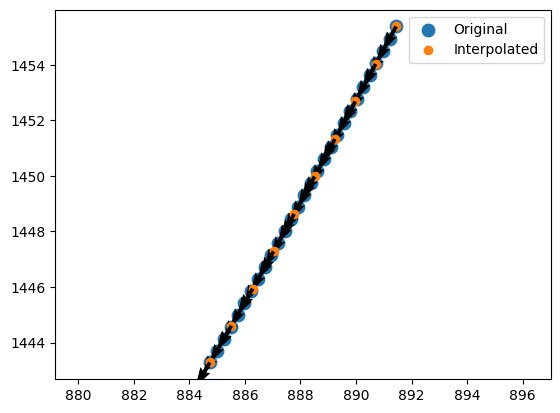

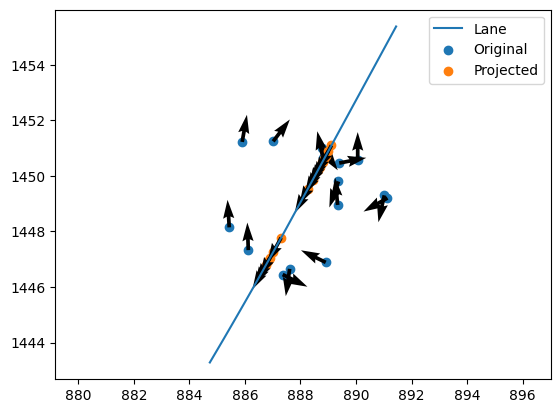

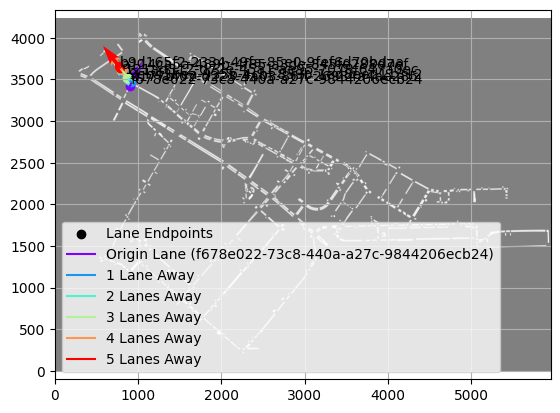

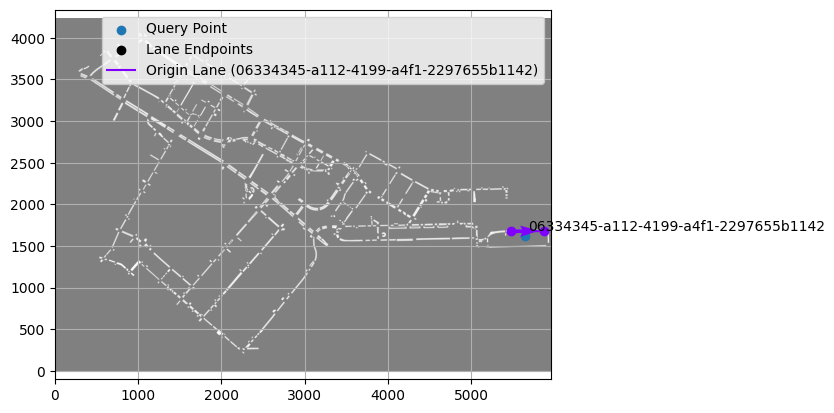

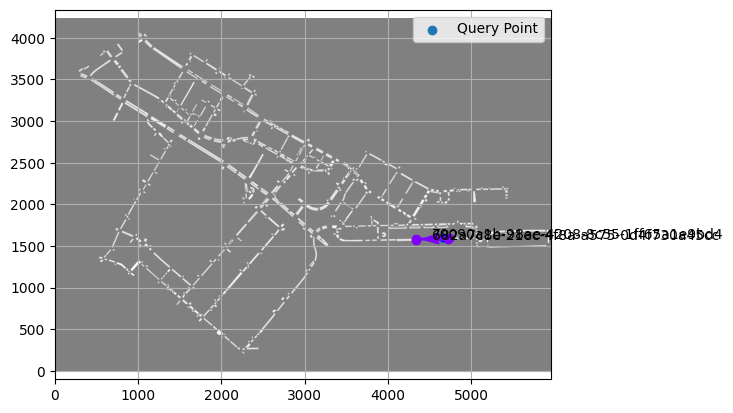

In [2]:


cache_path = Path("~/.unified_data_cache").expanduser()
map_api = MapAPI(cache_path)

### Loading random scene and initializing VectorMap.
env_name: str = np.random.choice(["nusc_mini"]) #, "lyft_sample", "nuplan_mini"])
scene_cache: Optional[SceneCache] = None
if env_name == "nuplan_mini":
    # Hardcoding scene_dt = 0.05s for now
    # (using nuPlan as our traffic light data example).
    random_scene: Scene = load_random_scene(cache_path, env_name, scene_dt=0.05)
    scene_cache = DataFrameCache(cache_path, random_scene)

    vec_map: VectorMap = map_api.get_map(
        f"{env_name}:{random_scene.location}", scene_cache=scene_cache
    )
else:
    random_location: Dict[str, str] = {
        "nusc_mini": np.random.choice(["boston-seaport", "singapore-onenorth"]),
        "lyft_sample": "palo_alto",
    }

    vec_map: VectorMap = map_api.get_map(
        f"{env_name}:{random_location[env_name]}", scene_cache=scene_cache
    )

print(f"Randomly chose {vec_map.env_name}, {vec_map.map_name} map.")

### Loading Lane used for the next few figures.
lane: RoadLane = vec_map.lanes[np.random.randint(0, len(vec_map.lanes))]

### Lane Interpolation (max_dist)
start = time.perf_counter()
interpolated: Polyline = lane.center.interpolate(max_dist=0.01)
end = time.perf_counter()
print(f"interpolate (max_dist) took {(end - start)*1000:.2f} ms")

fig, ax = plt.subplots()
ax.scatter(
    lane.center.points[:, 0], lane.center.points[:, 1], label="Original", s=80
)
ax.quiver(
    lane.center.points[:, 0],
    lane.center.points[:, 1],
    np.cos(lane.center.points[:, -1]),
    np.sin(lane.center.points[:, -1]),
)

ax.scatter(
    interpolated.points[:, 0], interpolated.points[:, 1], label="Interpolated"
)
ax.quiver(
    interpolated.points[:, 0],
    interpolated.points[:, 1],
    np.cos(interpolated.points[:, -1]),
    np.sin(interpolated.points[:, -1]),
)

ax.legend(loc="best")
ax.axis("equal")

### Lane Interpolation (num_pts)
start = time.perf_counter()
interpolated: Polyline = lane.center.interpolate(num_pts=10)
end = time.perf_counter()
print(f"interpolate (num_pts) took {(end - start)*1000:.2f} ms")

fig, ax = plt.subplots()
ax.scatter(
    lane.center.points[:, 0], lane.center.points[:, 1], label="Original", s=80
)
ax.quiver(
    lane.center.points[:, 0],
    lane.center.points[:, 1],
    np.cos(lane.center.points[:, -1]),
    np.sin(lane.center.points[:, -1]),
)

ax.scatter(
    interpolated.points[:, 0], interpolated.points[:, 1], label="Interpolated"
)
ax.quiver(
    interpolated.points[:, 0],
    interpolated.points[:, 1],
    np.cos(interpolated.points[:, -1]),
    np.sin(interpolated.points[:, -1]),
)

ax.legend(loc="best")
ax.axis("equal")

### Projection onto Lane
num_pts = 15
orig_pts = lane.center.midpoint + np.concatenate(
    [
        np.random.uniform(-3, 3, size=(num_pts, 2)),  # x,y offsets
        np.zeros(shape=(num_pts, 1)),  # no z offsets
        np.random.uniform(-np.pi, np.pi, size=(num_pts, 1)),  # headings
    ],
    axis=-1,
)
start = time.perf_counter()
proj_pts = lane.center.project_onto(orig_pts)
end = time.perf_counter()
print(f"project_onto ({num_pts} points) took {(end - start)*1000:.2f} ms")

fig, ax = plt.subplots()
ax.plot(lane.center.points[:, 0], lane.center.points[:, 1], label="Lane")
ax.scatter(orig_pts[:, 0], orig_pts[:, 1], label="Original")
ax.quiver(
    orig_pts[:, 0],
    orig_pts[:, 1],
    np.cos(orig_pts[:, -1]),
    np.sin(orig_pts[:, -1]),
)

ax.scatter(proj_pts[:, 0], proj_pts[:, 1], label="Projected")
ax.quiver(
    proj_pts[:, 0],
    proj_pts[:, 1],
    np.cos(proj_pts[:, -1]),
    np.sin(proj_pts[:, -1]),
)

ax.legend(loc="best")
ax.axis("equal")

### Lane Graph Visualization (with rasterized map in background)
fig, ax = plt.subplots()
map_img, raster_from_world = vec_map.rasterize(
    resolution=2,
    return_tf_mat=True,
    incl_centerlines=False,
    area_color=(255, 255, 255),
    edge_color=(0, 0, 0),
    scene_ts=100,
)
ax.imshow(map_img, alpha=0.5, origin="lower")
vec_map.visualize_lane_graph(
    origin_lane=np.random.randint(0, len(vec_map.lanes)),
    num_hops=5,
    raster_from_world=raster_from_world,
    ax=ax,
)
ax.axis("equal")
ax.grid(None)

### Closest Lane Query (with rasterized map in background)
# vec_map.extent is [min_x, min_y, min_z, max_x, max_y, max_z]
min_x, min_y, _, max_x, max_y, _ = vec_map.extent

mean_pt: np.ndarray = np.array(
    [
        np.random.uniform(min_x, max_x),
        np.random.uniform(min_y, max_y),
        0,
    ]
)

start = time.perf_counter()
lane: RoadLane = vec_map.get_closest_lane(mean_pt)
end = time.perf_counter()
print(f"get_closest_lane took {(end - start)*1000:.2f} ms")

fig, ax = plt.subplots()
map_img, raster_from_world = vec_map.rasterize(
    resolution=2,
    return_tf_mat=True,
    incl_centerlines=False,
    area_color=(255, 255, 255),
    edge_color=(0, 0, 0),
)
ax.imshow(map_img, alpha=0.5, origin="lower")
query_pt_map: np.ndarray = map_utils.transform_points(
    mean_pt[None, :2], raster_from_world
)[0]
ax.scatter(*query_pt_map, label="Query Point")
vec_map.visualize_lane_graph(
    origin_lane=lane, num_hops=0, raster_from_world=raster_from_world, ax=ax
)
ax.axis("equal")
ax.grid(None)

### Lanes Within Range Query (with rasterized map in background)
radius: float = 20.0

# vec_map.extent is [min_x, min_y, min_z, max_x, max_y, max_z]
min_x, min_y, _, max_x, max_y, _ = vec_map.extent

mean_pt: np.ndarray = np.array(
    [
        np.random.uniform(min_x, max_x),
        np.random.uniform(min_y, max_y),
        0,
    ]
)

start = time.perf_counter()
lanes: List[RoadLane] = vec_map.get_lanes_within(mean_pt, radius)
end = time.perf_counter()
print(f"get_lanes_within took {(end - start)*1000:.2f} ms")

fig, ax = plt.subplots()
img_resolution: float = 2
map_img, raster_from_world = vec_map.rasterize(
    resolution=img_resolution,
    return_tf_mat=True,
    incl_centerlines=False,
    area_color=(255, 255, 255),
    edge_color=(0, 0, 0),
)
ax.imshow(map_img, alpha=0.5, origin="lower")

query_pt_map: np.ndarray = map_utils.transform_points(
    mean_pt[None, :2], raster_from_world
)[0]
ax.scatter(*query_pt_map, label="Query Point")
circle2 = plt.Circle(
    (query_pt_map[0], query_pt_map[1]),
    radius * img_resolution,
    color="b",
    fill=False,
)
ax.add_patch(circle2)

for l in lanes:
    vec_map.visualize_lane_graph(
        origin_lane=l,
        num_hops=0,
        raster_from_world=raster_from_world,
        ax=ax,
        legend=False,
    )

ax.axis("equal")
ax.grid(None)
ax.legend(loc="best", frameon=True)

plt.show()
plt.close("all")